In [1]:
from glob import glob
import json
import os
from pathlib import Path
import pickle
import sys
import time

import cv2
import h5py
from matplotlib import animation
from matplotlib.colorbar import Colorbar
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import mplcursors
import numpy as np
import pandas as pd
from scipy import interpolate, signal, stats, fftpack

#### Change this path to point to your code

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp

In [4]:
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_evoked_traces, get_events_wdict, find_nearest_ind
from tbd_eeg.tbd_eeg.data_analysis.Utilities.behavior_movies import Movie, get_sync_frame_times
from allensdk.brain_observatory.ecephys.lfp_subsampling.subsampling import subsample_lfp, remove_lfp_offset
# from tbd_eeg.tbd_eeg.data_analysis.eeg_preprocessing import qualitycheck_trials

In [5]:
%matplotlib widget

In [10]:
plotsavedir = r'C:\Users\lesliec\OneDrive - Allen Institute\analysis\THstim_project\pilot videos'

# Load experiment

In [7]:
data_dir = Path(r"P:\\")
subject_csv = Path(r"C:\Users\lesliec\OneDrive - Allen Institute\Shared Documents - Lab 328\Projects\CL-CM stim\subject_metadata.csv")
all_subexp = pd.read_csv(subject_csv)
all_subexp.head()

,mouse,sex,DOB,strain,exp_folder,histology,EEG,stim_tip_distance,tiparea,dist_CL,color
0,mouse771424,F,NaN,C57BL/6J,THstim_d1_2024-11-14_11-28-16,True,False,300,TH,0.925338,tomato
1,mouse771424,F,NaN,C57BL/6J,THstim_d2_2024-11-15_10-51-49,True,False,300,CP,1.494992,firebrick
2,mouse771425,F,NaN,C57BL/6J,THstim_d1_2024-11-21_10-59-24,True,False,300,PAL,1.286954,limegreen
3,mouse771425,F,NaN,C57BL/6J,THstim_d2_2024-11-22_10-49-58,True,False,300,int,1.435270,forestgreen
4,mouse771426,M,NaN,C57BL/6J,THstim_d1_2024-12-19_12-19-39,True,False,100,AV,0.686477,violet


In [8]:
choose_sub = 7
exprow = all_subexp.iloc[choose_sub]
data_path = os.path.join(data_dir, exprow.mouse, exprow.exp_folder, 'experiment1', 'recording1')
exp = EEGexp(data_path, preprocess=False, make_stim_csv=False)
print(exp.mouse)

exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
print(exp_tag)

Experiment type: electrical stimulation
771427
THstim_d2


Stim electrode

In [9]:
stim_elec_file = os.path.join(exp.data_folder, r'stim_elec_location.json')
if os.path.exists(stim_elec_file):
    with open(stim_elec_file) as elec_file:
        stim_elec_data = json.load(elec_file)
    print(stim_elec_data)
else:
    print('Stim electrode location file not found.')

{'surface': {'area': 'RSPd1', 'ccf_coords': [270, 12, 204]}, 'tip': {'area': 'CL', 'ccf_coords': [263, 131, 198]}}


# Load other data

## Load events

In [11]:
simple_log_file = exp.stimulus_log_file[:exp.stimulus_log_file.find('estim_log')] + 'simple_' + exp.stimulus_log_file[exp.stimulus_log_file.find('estim_log'):]
if os.path.exists(simple_log_file):
    simple_log = pd.read_csv(simple_log_file)
elif os.path.exists(os.path.join(exp.data_folder, r'simple_estim_log.csv')):
    simple_log = pd.read_csv(os.path.join(exp.data_folder, r'simple_estim_log.csv'))
else:
    print('No simple log found')

In [12]:
simple_log.head()

,stim_type,parameter,duration,onset,offset,sweep
0,freq50Hz,10,20,1377.05180,1397.05193,0
1,freq50Hz,50,20,1488.10577,1508.10590,0
2,freq50Hz,50,40,1608.41940,1648.41965,0
3,freq50Hz,50,40,1748.36228,1788.36253,0
4,freq50Hz,100,40,1878.41344,1918.41369,0


## Load iso

In [13]:
iso_level, isots = exp.load_analog_iso()
iso_induction, iso_maintenance = exp.load_iso_times()

## Load pupil diameter

In [14]:
if len(glob(os.path.join(exp.data_folder, 'Pupileye*'), recursive=True)) > 0:
    pupil_file = glob(os.path.join(exp.data_folder, 'Pupileye*'), recursive=True)[0]
    pupildf = pd.read_csv(pupil_file)
  
    pupilts = pupildf.sync_time.values
    pupilD = pupildf.Largest_Radius.values
    ## smooth pupil diameter, then normalize ##
    sm_pupil = np.zeros_like(pupilD)
    k = 5 # filter window is actually k*2+1
    for i in range(k, len(pupilD)-k-1):
        sm_pupil[i] = np.mean(pupilD[i-k:i+k]) # each point is the average of k surrounding points
    sm_pupil[:k] = pupilD[:k]
    sm_pupil[-k-1:] = pupilD[-k-1:]
    pupil = sm_pupil / np.mean(pupildf.Eye_Diameter.values)
    print('{:d}% of frames do not have good pupil measurements'.format(int((np.sum(np.isnan(pupilD)) / len(pupilD)) * 100)))
else:
    print('No local Pupileye*.csv file. Check server.')

0% of frames do not have good pupil measurements


In [15]:
awake_pupil_mean = np.nanmean(sm_pupil[pupilts < iso_induction[0]])
awake_pupil_std = np.nanstd(sm_pupil[pupilts < iso_induction[0]])

## Load EEG data

### Plot some EEG signal

## Load LFP signal

In [16]:
collect_LFP = {
    'probeD': {'VISp': 305},
    'probeE': {'SSp-bfd': 290},
    'probeF': {'ACAd': 155, 'MOp': 215},
}
deltat = 10. # window size, s
ctx_LFPs = {}
# ctx_spectra = {}
for probei, chinfo in collect_LFP.items():
    print(probei)
    ## Load LFP as memmap ##
    lfp_ts = np.load(exp.ephys_params[probei]['lfp_timestamps'])
    lfp_data_mm = np.memmap(exp.ephys_params[probei]['lfp_continuous'], dtype='int16', mode='r').reshape(
        (len(lfp_ts), exp.ephys_params[probei]['num_chs']))
    for regi, chi in chinfo.items():
        print(' {}: Loading data...'.format(regi))
        ## Get chosen ch converted ##
        lfp_ch = lfp_data_mm[:, chi] * exp.ephys_params[probei]['bit_volts']
        ## Apply bandpass filter (reverse, filter in 1 direction, and reverse again to correct for analog filter phase shift) ##
        hardware_filter = signal.butter(1, Wn=[0.5, 500], btype='band', fs=exp.ephys_params[probei]['lfp_sample_rate'])
        lfp_ch = np.flip(signal.lfilter(*hardware_filter, np.flip(lfp_ch)))
        ## Store the LFP ##
        ctx_LFPs[regi] = [lfp_ts, lfp_ch]
    
        lfp_fs = exp.ephys_params[probei]['lfp_sample_rate']
        
        ### Get the spectra for rest/run/iso ###
        # print('  Getting spectra...')
        # ctx_spectra[regi] = {}
        # ## Get deltat-sized bins and associated speeds ##
        # awakebins = np.arange(lfp_ts[0], iso_induction[0], deltat)
        # firstind = np.nonzero(stim_log.onset.values > iso_maintenance[0])[0][0]
        # isobins = np.arange(iso_maintenance[0], stim_log.onset.values[firstind], deltat)
        # tempsp = []
        # for x in awakebins:
        #     tempsp.append(np.mean(speed[np.nonzero((speedts >= x) & (speedts < x + deltat))[0]]))
        # awakespeeds = np.array(tempsp)[:-1]
        # tempsp = []
        # for x in isobins:
        #     tempsp.append(np.mean(speed[np.nonzero((speedts >= x) & (speedts < x + deltat))[0]]))
        # isospeeds = np.array(tempsp)[:-1]
        # ## Get awake spectra ##
        # awake_Pxx = []
        # for timei in awakebins[:-1]:
        #     tinds = np.nonzero((lfp_ts >= timei) & (lfp_ts < timei + deltat))[0]
        #     frex, Pxx = signal.welch(
        #         lfp_ch[tinds], exp.ephys_params[probei]['lfp_sample_rate'], nperseg=2 * exp.ephys_params[probei]['lfp_sample_rate'],
        #     )
        #     awake_Pxx.append(Pxx)
        # awake_Pxx = np.array(awake_Pxx)
        # ctx_spectra[regi]['rest'] = [frex, np.mean(awake_Pxx[awakespeeds == 0, :], axis=0)]
        # ctx_spectra[regi]['run'] = [frex, np.mean(awake_Pxx[awakespeeds > 1, :], axis=0)]
        # ## Get anesthetized spectra ##
        # iso_Pxx = []
        # for timei in isobins[:-1]:
        #     tinds = np.nonzero((lfp_ts >= timei) & (lfp_ts < timei + deltat))[0]
        #     frex, Pxx = signal.welch(
        #         lfp_ch[tinds], exp.ephys_params[probei]['lfp_sample_rate'], nperseg=2 * exp.ephys_params[probei]['lfp_sample_rate'],
        #     )
        #     iso_Pxx.append(Pxx)
        # iso_Pxx = np.array(iso_Pxx)
        # ctx_spectra[regi]['iso'] = [frex, np.mean(iso_Pxx[isospeeds == 0, :], axis=0)]
        print('  ...done.\n')

probeD
 VISp: Loading data...
  ...done.

probeE
 SSp-bfd: Loading data...
  ...done.

probeF
 ACAd: Loading data...
  ...done.

 MOp: Loading data...
  ...done.



In [17]:
eventind = 4
stimevent = simple_log.iloc[eventind]
deltat = [10, 60]
plotwin = [stimevent.onset - deltat[0], stimevent.offset + deltat[1]]

Text(0.5, 0.98, 'Mouse 771427: THstim_d2, stim in CL\nfreq50Hz - 100uA, duration=40 s (event4)')

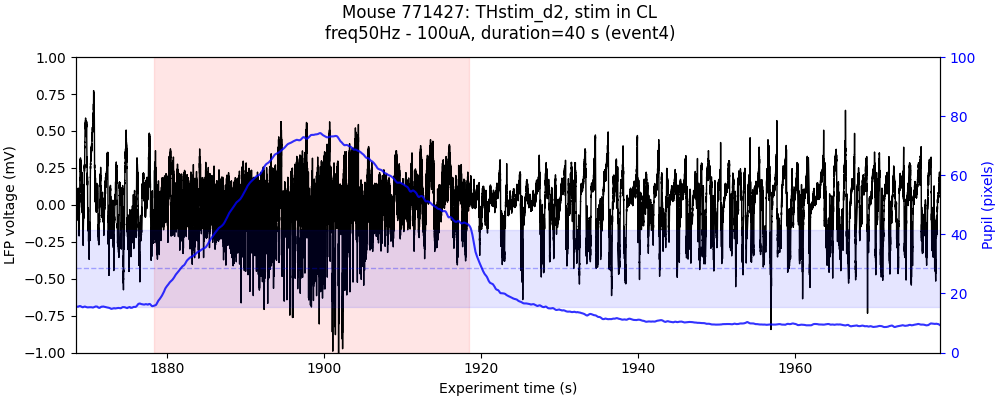

In [18]:
regi = 'MOp'
lfpx = ctx_LFPs[regi][0]
lfpy = ctx_LFPs[regi][1] * 1E-3
tsinds = np.nonzero((lfpx > plotwin[0]) & (lfpx < plotwin[1]))[0]

fig, ax = plt.subplots(figsize=(10,4), constrained_layout=True)
ax.axvspan(stimevent.onset, stimevent.offset, color='r', alpha=0.1)
ax.plot(lfpx[tsinds], lfpy[tsinds], color='k', linewidth=1.0)
ax.set_xlim(plotwin)
ax.set_ylim([-1, 1])
ax.set_xlabel('Experiment time (s)')
ax.set_ylabel('LFP voltage (mV)')

pax = ax.twinx()
pax.axhspan(awake_pupil_mean - awake_pupil_std, awake_pupil_mean + awake_pupil_std, color='b', alpha=0.1)
pax.axhline(awake_pupil_mean, color='b', linewidth=1.0, linestyle='dashed', alpha=0.3)
pax.plot(pupilts, sm_pupil, color='b', alpha=0.8, label='pupil')
pax.set_ylabel('Pupil (pixels)', color='b')
pax.tick_params(axis='y', colors='b')
pax.set_ylim([0, 100])

fig.suptitle('Mouse {}: {}, stim in {}\n{} - {:d}uA, duration={:d} s (event{:d})'.format(
    exp.mouse, exp_tag, stim_elec_data['tip']['area'], stimevent.stim_type, stimevent.parameter, stimevent.duration, eventind))

## Load behavior videos

In [19]:
pupil_video = Movie(
    filepath = exp.pupilmovie_file,
    sync_filepath = exp.sync_file,
    sync_channel = 'eyetracking'
)
pupil_ts = pupil_video.sync_timestamps
body_video = Movie(
    filepath = exp.bodymovie_file,
    sync_filepath = exp.sync_file,
    sync_channel = 'behavior'
)
body_ts = body_video.sync_timestamps

In [20]:
print(pupil_ts[:10])
print(np.diff(pupil_ts)[:10])

[14.37459 14.39026 14.40603 14.43976 14.47265 14.50603 14.53932 14.57255
 14.60631 14.6395 ]
[0.01567 0.01577 0.03373 0.03289 0.03338 0.03329 0.03323 0.03376 0.03319
 0.14854]


In [21]:
print(body_ts[:10])
print(np.diff(body_ts)[:10])

[14.47866 14.49474 14.50657 14.52288 14.53984 14.55628 14.57314 14.58976
 14.60681 14.62278]
[0.01608 0.01183 0.01631 0.01696 0.01644 0.01686 0.01662 0.01705 0.01597
 0.16592]


## Make video with LFP signal

In [22]:
eventind = 4
stimevent = simple_log.iloc[eventind]
deltat = [10, 60]
plotwin = [stimevent.onset - deltat[0], stimevent.offset + deltat[1]]

regi = 'MOp'
lfpx = ctx_LFPs[regi][0]
lfpy = ctx_LFPs[regi][1] * 1E-3

In [23]:
plotwin

[1868.41344, 1978.41369]

In [24]:
def update(clock_time):
    
    # body cam movie
    bplot.set_data(body_video.get_frame(time=clock_time, timestamps='sync'))

    # pupil cam movie
    pplot.set_data(pupil_video.get_frame(time=clock_time, timestamps='sync'))

    # LFP plot
    spline.set_data([clock_time, clock_time], [-1,1])

    # text
    if clock_time >= stimevent.onset:
        if clock_time < stimevent.offset:
            event_text.set_text('STIM ON')
            event_text.set_color('g')
        else:
            event_text.set_text('STIM OFF')
            event_text.set_color('r')
    
    return fig

In [25]:
movie_name = os.path.join(
    plotsavedir,
    'm{}{}_videoLFPpup_{}{:d}ua-{:d}s_e{:d}_2x.mp4'.format(exp.mouse, exp_tag, stimevent.stim_type[4:], stimevent.parameter, stimevent.duration, eventind))
print(movie_name)

C:\Users\lesliec\OneDrive - Allen Institute\analysis\THstim_project\pilot videos\m771427THstim_d2_videoLFPpup_50Hz100ua-40s_e4_2x.mp4


In [26]:
frame_times = pupil_ts[np.nonzero((pupil_ts > plotwin[0]) & (pupil_ts < plotwin[1]))[0]]
print(len(frame_times))

3300


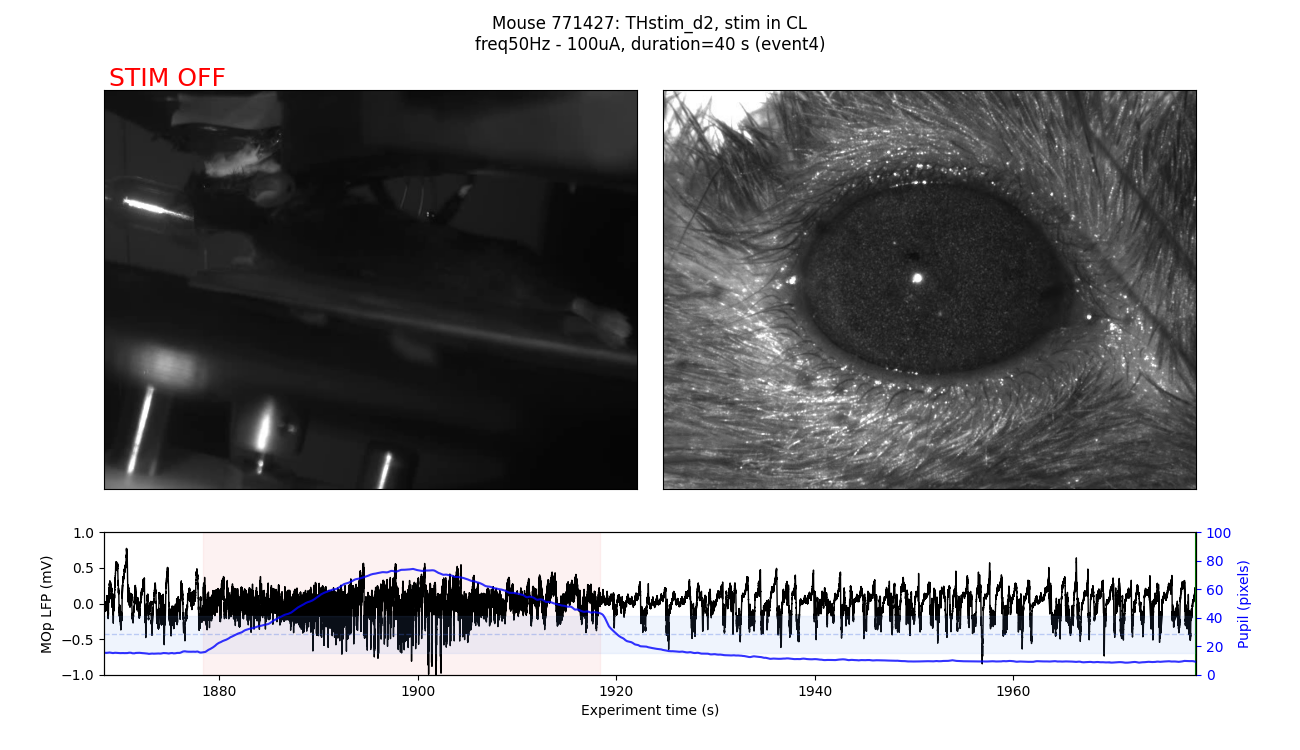

In [27]:
fig = plt.figure(figsize=(13, 7.5))
fig.patch.set_facecolor('whitesmoke')

# make grid for subplots
gs = GridSpec(2, 2, figure=fig, height_ratios=[3, 1], left=0.08, right=0.92, bottom=0.1, top=0.9, wspace=0.05, hspace=0.1)
ax_body = fig.add_subplot(gs[0, 0])
ax_eye = fig.add_subplot(gs[0, 1])
ax_lfp = fig.add_subplot(gs[1, :])

# body cam movie
bplot = ax_body.imshow(body_video.get_frame(time=plotwin[0], timestamps='sync'))
ax_body.get_xaxis().set_visible(False)
ax_body.get_yaxis().set_visible(False)

# pupil cam movie
pplot = ax_eye.imshow(pupil_video.get_frame(time=plotwin[0], timestamps='sync'))
ax_eye.get_xaxis().set_visible(False)
ax_eye.get_yaxis().set_visible(False)

# LFP plot
tsinds = np.nonzero((lfpx > plotwin[0]) & (lfpx < plotwin[1]))[0]
ax_lfp.axvspan(stimevent.onset, stimevent.offset, color='lightcoral', alpha=0.1)
ax_lfp.plot(lfpx[tsinds], lfpy[tsinds], color='k', linewidth=1.0)
ax_lfp.set_xlim(plotwin)
ax_lfp.set_ylim([-1, 1])
ax_lfp.set_xlabel('Experiment time (s)')
ax_lfp.set_ylabel('{} LFP (mV)'.format(regi))
spline = ax_lfp.axvline(plotwin[0], color='g')

pax = ax_lfp.twinx()
pax.axhspan(awake_pupil_mean - awake_pupil_std, awake_pupil_mean + awake_pupil_std, color='cornflowerblue', alpha=0.1)
pax.axhline(awake_pupil_mean, color='royalblue', linewidth=1.0, linestyle='dashed', alpha=0.3)
pax.plot(pupilts, sm_pupil, color='b', alpha=0.8, label='pupil')
pax.set_ylabel('Pupil (pixels)', color='b')
pax.tick_params(axis='y', colors='b')
pax.set_ylim([0, 100])

fig.suptitle('Mouse {}: {}, stim in {}\n{} - {:d}uA, duration={:d} s (event{:d})'.format(exp.mouse, exp_tag, stim_elec_data['tip']['area'], stimevent.stim_type, stimevent.parameter, stimevent.duration, eventind))
event_text = ax_body.text(5, -5, 'STIM OFF', fontsize=18, color='r')

## from Ethan
anim = animation.FuncAnimation(fig, update, init_func=None, frames=frame_times, interval=200, blit=False)
anim.save(movie_name, writer='ffmpeg', fps=60, extra_args=['-vcodec', 'libx264'], dpi=300)

## Make video (videos only)

In [47]:
eventind = 0
stimevent = stim_log.iloc[eventind]
deltat = 5.0
plotwin = [stimevent.onset - deltat, stimevent.offset + deltat]

In [55]:
plotwin

[2072.24164, 2102.24175]

In [58]:
def update(clock_time):
    
    # body cam movie
    bplot.set_data(body_video.get_frame(time=clock_time, timestamps='sync'))

    # pupil cam movie
    pplot.set_data(pupil_video.get_frame(time=clock_time, timestamps='sync'))

    # text
    if clock_time >= stimevent.onset:
        if clock_time < stimevent.offset:
            event_text.set_text('STIM ON')
            event_text.set_color('g')
        else:
            event_text.set_text('STIM OFF')
            event_text.set_color('r')
    
    return fig

In [59]:
movie_name = os.path.join(
    plotsavedir,
    'mouse{}_{}_videos_{}-{:d}ua-{:d}s_event{:d}.mp4'.format(exp.mouse, exp_tag, stimevent.stim_type, stimevent.parameter, stimevent.duration, eventind))
print(movie_name)

C:\Users\lesliec\OneDrive - Allen Institute\data\plots\THstim_project\pilot videos\mouse771424_THstim_d1_videos_freq50Hz-10ua-20s_event0.mp4


In [60]:
frame_times = pupil_ts[np.nonzero((pupil_ts > plotwin[0]) & (pupil_ts < plotwin[1]))[0]]
print(len(frame_times))

900


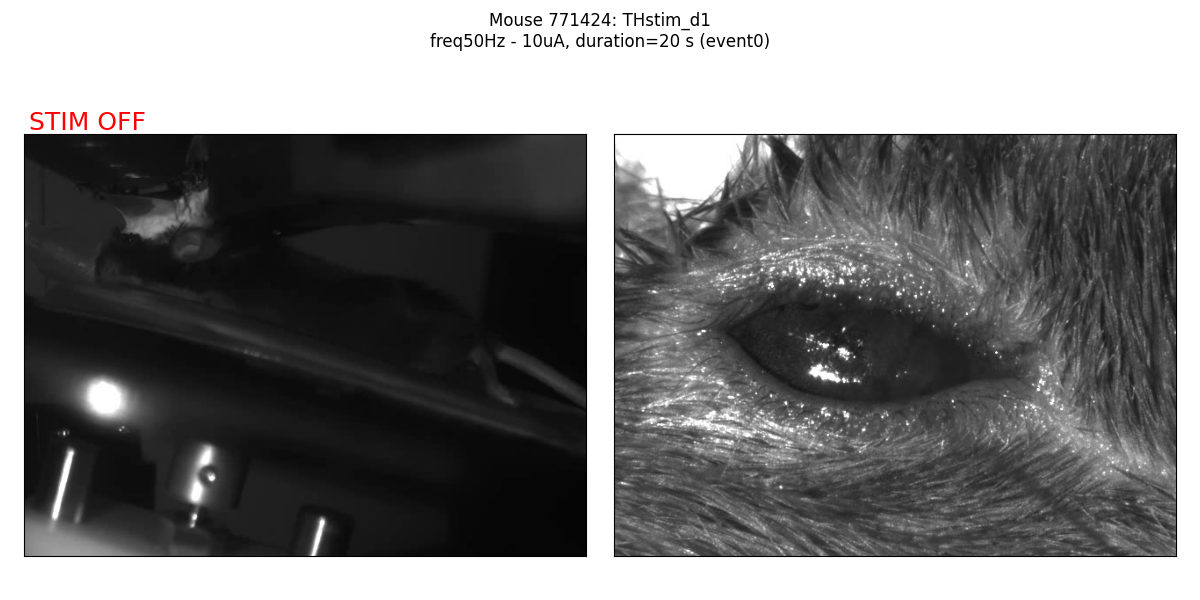

In [61]:
fig = plt.figure(figsize=(12, 6))
fig.patch.set_facecolor('whitesmoke')
# make grid for subplots
gs = GridSpec(1, 2, figure=fig, left=0.02, right=0.98, bottom=0.05, top=0.8, wspace=0.05)
ax_body = fig.add_subplot(gs[0])
ax_eye = fig.add_subplot(gs[1])
# body cam movie
bplot = ax_body.imshow(body_video.get_frame(time=plotwin[0], timestamps='sync'))
ax_body.get_xaxis().set_visible(False)
ax_body.get_yaxis().set_visible(False)
# pupil cam movie
pplot = ax_eye.imshow(pupil_video.get_frame(time=plotwin[0], timestamps='sync'))
ax_eye.get_xaxis().set_visible(False)
ax_eye.get_yaxis().set_visible(False)

fig.suptitle('Mouse {}: {}\n{} - {:d}uA, duration={:d} s (event{:d})'.format(exp.mouse, exp_tag, stimevent.stim_type, stimevent.parameter, stimevent.duration, eventind))
event_text = ax_body.text(5, -5, 'STIM OFF', fontsize=18, color='r')

## from Ethan
anim = animation.FuncAnimation(fig, update, init_func=None, frames=frame_times, interval=200, blit=False)
# anim.save(movie_name, writer='ffmpeg', fps=30, extra_args=['-vcodec', 'libx264'], dpi=300)

### Set up video clips

## Make video

In [23]:
def update(clock_time):
    
    # body cam movie
    bplot.set_data(body_video.get_frame(time=clock_time, timestamps='sync'))

    # pupil cam movie
    pplot.set_data(pupil_video.get_frame(time=clock_time, timestamps='sync'))

    # eeg plot
    # spline.set_data([clock_time - SWDevent.onset, clock_time - SWDevent.onset], [-1,1])
    spline.set_data([clock_time, clock_time], [-1,1])
    
    return fig

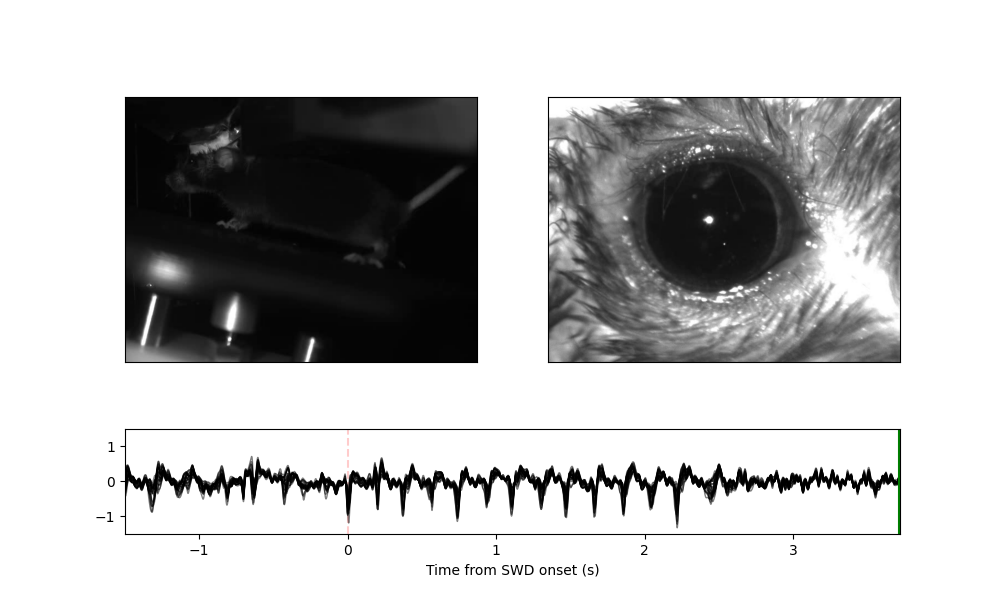

In [32]:
SWDind = 512
SWDevent = autoSWD_df.iloc[SWDind]
deltat = 1.5
plotwin = [SWDevent.onset - deltat, SWDevent.offset + deltat]

movie_name = os.path.join(plotsavedir, 'SWD{:d}_EEG_videos.mp4'.format(SWDind))
frame_times = pupil_ts[np.nonzero((pupil_ts > plotwin[0]) & (pupil_ts < plotwin[1]))[0]]

fig = plt.figure(figsize=(10, 6))
fig.patch.set_facecolor('whitesmoke')
# make grid for subplots
gs = GridSpec(2, 2, figure=fig, height_ratios=[3, 1])
ax_body = fig.add_subplot(gs[0, 0])
ax_eye = fig.add_subplot(gs[0, 1])
ax_eeg = fig.add_subplot(gs[1, :])
# body cam movie
bplot = ax_body.imshow(body_video.get_frame(time=plotwin[0], timestamps='sync'))
ax_body.get_xaxis().set_visible(False)
ax_body.get_yaxis().set_visible(False)
# pupil cam movie
pplot = ax_eye.imshow(pupil_video.get_frame(time=plotwin[0], timestamps='sync'))
ax_eye.get_xaxis().set_visible(False)
ax_eye.get_yaxis().set_visible(False)
# EEG plot
eeginds = np.nonzero((eeg_ts > plotwin[0]) & (eeg_ts < plotwin[1]))[0]
ax_eeg.axvline(0, color='r', linestyle='dashed', alpha=0.2)
ax_eeg.plot(eeg_ts[eeginds] - SWDevent.onset, filt_data[eeginds, :][:, GOOD_CHS], color='k', linewidth=1.0, alpha=0.5)
ax_eeg.set_xlim(plotwin - SWDevent.onset)
ax_eeg.set_xlabel('Time from SWD onset (s)')
ax_eeg.set_ylim([-1.5, 1.5])
spline = ax_eeg.axvline(plotwin[0] - SWDevent.onset, color='g')

## from Ethan
anim = animation.FuncAnimation(fig, update, init_func=None, frames=frame_times, interval=60, blit=False)
anim.save(movie_name, writer='ffmpeg', fps=10, extra_args=['-vcodec', 'libx264'], dpi=300)

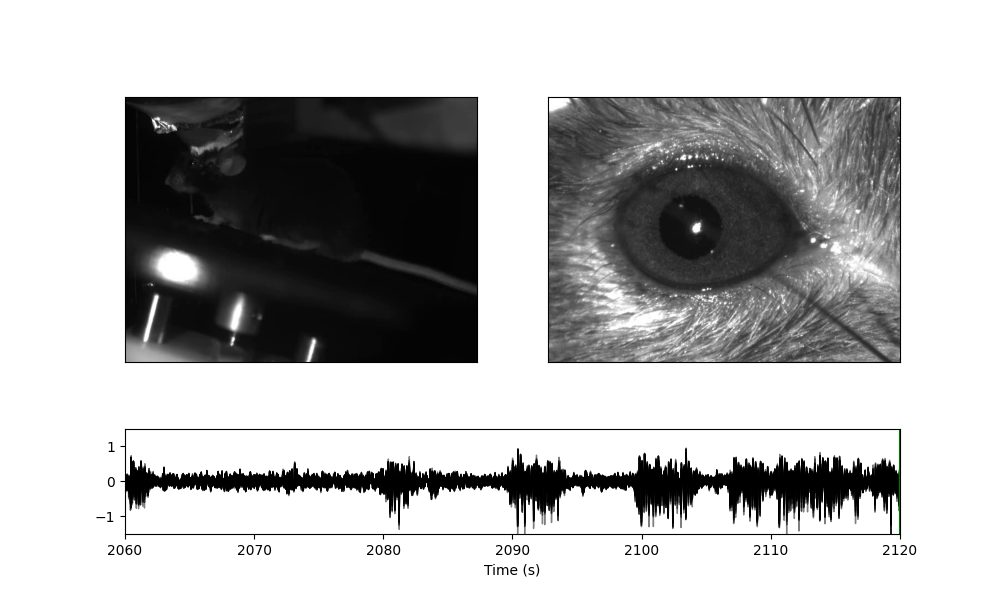

In [24]:
window = [2060, 2120]

movie_name = os.path.join(plotsavedir, 'window2_EEG_videos.mp4')
frame_times = pupil_ts[np.nonzero((pupil_ts > window[0]) & (pupil_ts < window[1]))[0]]

fig = plt.figure(figsize=(10, 6))
fig.patch.set_facecolor('whitesmoke')
# make grid for subplots
gs = GridSpec(2, 2, figure=fig, height_ratios=[3, 1])
ax_body = fig.add_subplot(gs[0, 0])
ax_eye = fig.add_subplot(gs[0, 1])
ax_eeg = fig.add_subplot(gs[1, :])
# body cam movie
bplot = ax_body.imshow(body_video.get_frame(time=window[0], timestamps='sync'))
ax_body.get_xaxis().set_visible(False)
ax_body.get_yaxis().set_visible(False)
# pupil cam movie
pplot = ax_eye.imshow(pupil_video.get_frame(time=window[0], timestamps='sync'))
ax_eye.get_xaxis().set_visible(False)
ax_eye.get_yaxis().set_visible(False)
# EEG plot
eeginds = np.nonzero((eeg_ts > window[0]) & (eeg_ts < window[1]))[0]
ax_eeg.axvline(0, color='r', linestyle='dashed', alpha=0.2)
ax_eeg.plot(eeg_ts[eeginds], filt_data[eeginds, :][:, GOOD_CHS], color='k', linewidth=1.0, alpha=0.5)
ax_eeg.set_xlim(window)
ax_eeg.set_xlabel('Time (s)')
ax_eeg.set_ylim([-1.5, 1.5])
spline = ax_eeg.axvline(window[0], color='g')

## from Ethan
anim = animation.FuncAnimation(fig, update, init_func=None, frames=frame_times, interval=60, blit=False)
anim.save(movie_name, writer='ffmpeg', fps=30, extra_args=['-vcodec', 'libx264'], dpi=300)

### Load units and spikes

In [14]:
fn_units_info = os.path.join(exp.data_folder, 'evoked_data', 'all_units_info.csv')
if os.path.exists(fn_units_info):
    unit_info = pd.read_csv(fn_units_info)
    with open(os.path.join(exp.data_folder, 'evoked_data', 'units_allspikes.pkl'), 'rb') as unit_file:
        all_unit_all_spikes = pickle.load(unit_file)
else:
    print('{} not found. Not analyzing this subject.'.format(fn_units_stats))

unit_info.head()

,unit_id,probe,peak_ch,depth,spike_duration,region,CCF_AP,CCF_DV,CCF_ML,parent_region
0,B0,probeB,0,3640,0.576884,AMv,253,179,195,other-TH
1,B4,probeB,1,3640,0.508208,AMv,253,179,195,other-TH
2,B9,probeB,3,3620,0.590620,AMv,253,178,195,other-TH
3,B10,probeB,4,3600,0.480737,AMv,253,177,194,other-TH
4,B11,probeB,5,3600,0.480737,AMv,253,177,194,other-TH


In [15]:
for pregi in np.unique(unit_info['parent_region'].values):
    pudf = unit_info[unit_info['parent_region'] == pregi]
    print('{}: {:d} units'.format(pregi, len(pudf)))

HIP: 113 units
MO: 73 units
PAL: 69 units
RT-TH: 12 units
SM-TH: 59 units
SS: 135 units
STR: 97 units
VIS: 24 units
other-TH: 208 units


### Load LFP

In [16]:
probe_list = [x.replace('_sorted', '') for x in exp.experiment_data if 'probe' in x]
print(probe_list)

['probeB', 'probeC', 'probeD', 'probeF']


In [ ]:
LFP_traces = {}
for pbi, probei in enumerate(probe_list):

In [17]:
probei = 'probeD'

lfp_ts = np.load(exp.ephys_params[probei]['lfp_timestamps'])
lfp_mm = np.memmap(exp.ephys_params[probei]['lfp_continuous'], dtype='int16', shape=(lfp_ts.size, exp.ephys_params[probei]['num_chs']), mode='r')

In [18]:
print(lfp_ts.shape)
print(lfp_mm.shape)

(16506874,)
(16506874, 384)


In [19]:
with open(exp.ephys_params[probei]['probe_info']) as data_file:
    data = json.load(data_file)
    
## Get info ##
npx_allch = np.array(data['channel']) # this is an array from 0 to 384
surface_ch = int(data['surface_channel']) # the electrode we said was at the brain surface
air_ch = int(data['air_channel']) # the electrode at the ACSF/air border
allch_z = np.array(data['vertical_pos']) # vertical pos of each elec (um), rel to the tip
ref_mask = np.array(data['mask']) # contains a False for Npx reference channels and "bad chs"

print(surface_ch)
print(air_ch)

370
384


In [20]:
allch_areas = np.array(data['area_ch'])
print(np.unique(allch_areas))

['CP' 'RT' 'SSp-bfd1' 'SSp-bfd2/3' 'SSp-bfd4' 'SSp-bfd5' 'SSp-bfd6a'
 'SSp-bfd6b' 'VAL' 'VL' 'VPL' 'ccb' 'em' 'fi' 'fiber tracts' 'null' 'or'
 'st']


In [30]:
ROI = 'SSp'
ROImask = [True if ROI in x else False for x in allch_areas]
print(np.sum(ROImask))

125


Testing

In [23]:
SWDind = 40
SWDevent = autoSWD_df.iloc[SWDind]
deltat = 1.0

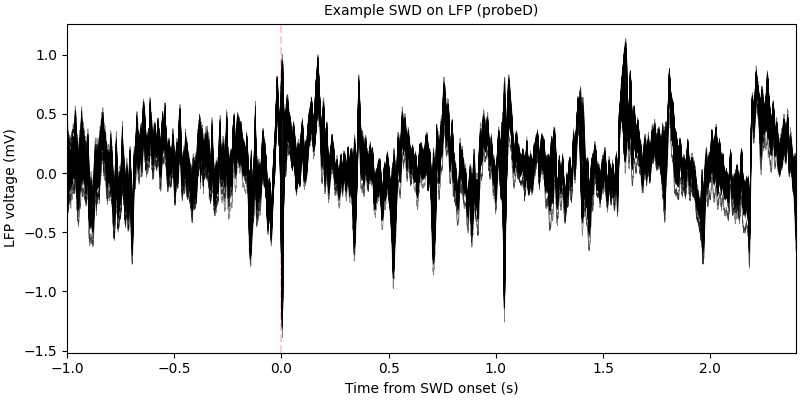

In [26]:
timezero = SWDevent.onset
pwin = [SWDevent.onset - deltat, SWDevent.offset + deltat]

fig, ax = plt.subplots(figsize=(8,4), constrained_layout=True)

tsinds = np.nonzero((lfp_ts > pwin[0]) & (lfp_ts < pwin[1]))[0]
ax.axvline(0, color='r', linestyle='dashed', alpha=0.2)
ax.plot(lfp_ts[tsinds] - timezero, lfp_mm[tsinds, :][:, ROImask] * exp.ephys_params[probei]['bit_volts'] * 1e-3, color='k', linewidth=0.5, alpha=0.5)
# ax.plot(lfp_ts[tsinds] - timezero, saline_ref[tsinds] * exp.ephys_params[probei]['bit_volts'] * 1e-3, color='m', linewidth=1.0, alpha=0.8)
ax.set_xlim(pwin - timezero)
ax.set_xlabel('Time from SWD onset (s)')
ax.set_ylabel('LFP voltage (mV)')
ax.set_title('Example SWD on LFP ({})'.format(probei))

### SAVE ###
fig_name = 'SWD_LFPonly_example{:d}.png'.format(SWDind)
# fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

### Plot an SWD event

In [32]:
plot_regions = ['other-TH', 'SM-TH', 'RT-TH', 'VIS', 'SS', 'MO']

In [53]:
SWDind = 257
SWDevent = autoSWD_df.iloc[SWDind]
print(SWDevent.duration)

1.339186593469094


In [59]:
deltat = 1.0 # time around SWD to plot, s

Plot EEG + LFP + all region raster

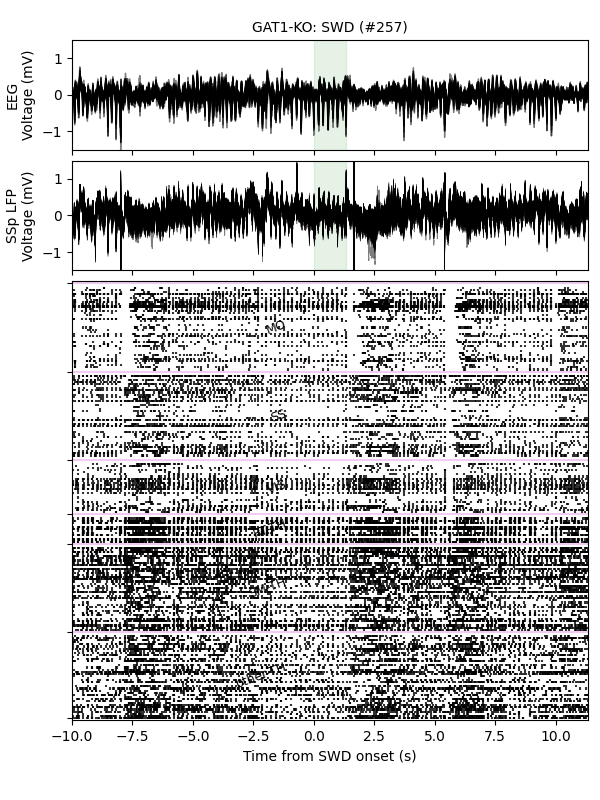

In [60]:
## Plot one half-slide ##
timezero = SWDevent.onset
pwin = [SWDevent.onset - deltat, SWDevent.offset + deltat]
umax = 40

fig = plt.figure(figsize=(6, 8)) # (10,10)
gs = fig.add_gridspec(ncols=1, nrows=3, left=0.12, right=0.98, top=0.95, bottom=0.1, hspace=0.05, height_ratios=[1, 1, 4])
EEGax = fig.add_subplot(gs[0])
LFPax = fig.add_subplot(gs[1])
rasterax = fig.add_subplot(gs[2])

## Plot EEG ##
eeginds = np.nonzero((eeg_ts > pwin[0]) & (eeg_ts < pwin[1]))[0]
EEGax.axvspan(0, SWDevent.duration, color='g', alpha=0.1)
EEGax.plot(eeg_ts[eeginds] - timezero, filt_data[eeginds, :][:, GOOD_CHS], color='k', linewidth=1.0, alpha=0.5)
EEGax.set_xlim(pwin - timezero)
EEGax.set_xticklabels([])
EEGax.set_ylim([-1.5, 1.5])
# EEGax.set_ylim([-0.25, 0.25])
EEGax.set_ylabel('EEG\nVoltage (mV)')
EEGax.set_title('GAT1-KO: SWD (#{:d})'.format(SWDind))
# EEGax.set_title('Wild type (not litter mate): spontaneous activity')

## Plot LFP ##
tsinds = np.nonzero((lfp_ts > pwin[0]) & (lfp_ts < pwin[1]))[0]
LFPax.axvspan(0, SWDevent.duration, color='g', alpha=0.1)
LFPax.plot(lfp_ts[tsinds] - timezero, lfp_mm[tsinds, :][:, ROImask] * exp.ephys_params[probei]['bit_volts'] * 1e-3, color='k', linewidth=0.5, alpha=0.5)
LFPax.set_xlim(pwin - timezero)
LFPax.set_xticklabels([])
LFPax.set_ylim([-1.5, 1.5])
LFPax.set_ylabel('{} LFP\nVoltage (mV)'.format(ROI))

## Plot raster ##
# rasterax.axvspan(0, SWDevent.duration, color='g', alpha=0.1)
last_ind = 0
regb = [last_ind]
for ii, pregi in enumerate(plot_regions):
    regdf = unit_info[unit_info['parent_region'] == pregi].sort_values(by='depth', ascending=False).reset_index(drop=True)
    if len(regdf) > umax:
        punitinds = np.random.choice(range(len(regdf)), size=umax, replace=False)
    else:
        punitinds = range(len(regdf))
    for indi in punitinds:
        urow = regdf.iloc[indi]
        uspiketimes = all_unit_all_spikes[urow.unit_id]['spikes']
        SWDspikes = uspiketimes[
            np.nonzero((uspiketimes > pwin[0]) & (uspiketimes < pwin[1]))[0]
        ]
        rasterax.eventplot(SWDspikes - timezero, lineoffsets=last_ind, linelengths=1.0, color='black', alpha=0.8)
        last_ind += 1
    rasterax.annotate(
        '{}'.format(pregi), xy=(-1.05, last_ind - len(punitinds)/2), xycoords='data',
        annotation_clip=False, rotation=20, ha='right', va='center', fontsize=9
    )
    last_ind += 2
    regb.append(last_ind - 1)
    rasterax.axhline(last_ind - 1, color='m', alpha=0.2)

rasterax.set_ylim(-1, last_ind)
rasterax.set_xlim(pwin - timezero)
rasterax.set_xlabel('Time from SWD onset (s)')
rasterax.set_yticks(regb)
rasterax.set_yticklabels([])

### SAVE ###
fig_name = 'SWD_EEG_LFP_NPX_example{:d}.png'.format(SWDind)
# fig_name = 'spont_EEG_NPX_example.png'
# fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)